In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sat Dec 23 21:38:29 2023

@author: DELL
"""

import os
import cv2
import time
import random
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam


import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import keras.layers

from tensorflow.keras.applications import Xception
from tensorflow.keras import layers, Sequential
from tensorflow.keras.models import Model
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from sklearn.metrics import accuracy_score
from tensorflow.keras import layers, metrics
from sklearn.metrics import confusion_matrix


random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)

ROOT = r"C:\Users\DELL\Downloads\Data\Product Recoginition"
Validation_Data = r"C:\Users\DELL\Downloads\Data\Product Recoginition\Validation Data"
Training_Data = r"C:\Users\DELL\Downloads\Data\Product Recoginition\Training Data"

def is_image_readable(image_path):
    try:
        # Attempt to read the image
        img = cv2.imread(image_path)

        if img is None:
            return False
        return True
    except Exception as e:
        print(f"Error reading image: {image_path}")
        return False


def getFiles(path=""):
    imlist = {}
    count = 0
   
    for each in os.listdir(path):
        imlist[each] = []
        for imagefile in os.listdir(path + '/' + each):
            image_path = path + '/' + each + '/' + imagefile
            if is_image_readable(image_path):
                # Read the image using OpenCV
                im = cv2.imread(image_path)

                # Convert BGR to RGB
                im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
                im = cv2.resize(im, (128, 128))

                # Resize the image

                # Apply data augmentation
               
                imlist[each].append(im)
                count += 1

               
            else:
                continue

    return [imlist, count]

   

def look(directory):
    folders = os.listdir(directory)

    train_list = {}
    for folder in folders:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        train_list[folder] = num_files

    return train_list

#train_list = look(Training_Data)
train_list, _ = getFiles(Training_Data)
val_list, _=getFiles(Validation_Data)
print("Length of training list:", len(train_list))
print(len(train_list.items()))
print("\ntraing List:", train_list)
#val_list = look(Validation_Data)
print("Length of training list:", len(val_list))
print("\ntraing List:", val_list)
def create_triplets(directory, folder_list, max_files=14):
    triplets = []
    folders = list(folder_list.keys())

    for folder in folders:
        path = os.path.join(directory, folder)
        files = list(os.listdir(path))[:max_files]
        num_files = len(files)

        for i in range(num_files - 1):
            for j in range(i + 1, num_files):
                anchor_filename = f"web{i+1}.png"
                positive_filename = f"web{j}.png"

                anchor_path = os.path.join(path, anchor_filename)
                positive_path = os.path.join(path, positive_filename)

                if is_image_readable(anchor_path) and is_image_readable(positive_path):
                    anchor_image = cv2.imread(anchor_path)
                    positive_image = cv2.imread(positive_path)

                    anchor_image = cv2.cvtColor(anchor_image, cv2.COLOR_BGR2RGB)
                    positive_image = cv2.cvtColor(positive_image, cv2.COLOR_BGR2RGB)

                    anchor_image = cv2.resize(anchor_image, (128, 128))
                    positive_image = cv2.resize(positive_image, (128, 128))

                    anchor = (folder, anchor_image)
                    positive = (folder, positive_image)

                    # Find a negative image
                    neg_folder = folder
                    while neg_folder == folder:
                        neg_folder = random.choice(folders)
                    neg_file = random.randint(0, len(folder_list[neg_folder]) - 1)
                    neg_filename = f"web{neg_file + 1}.png"  # Adding 1 to avoid a 0 filename
                    neg_path = os.path.join(directory, neg_folder, neg_filename)

                    if is_image_readable(neg_path):
                        neg_image = cv2.imread(neg_path)
                        neg_image = cv2.cvtColor(neg_image, cv2.COLOR_BGR2RGB)
                        neg_image = cv2.resize(neg_image, (128, 128))
                        negative = (neg_folder, neg_image)

                        triplets.append((anchor, positive, negative))
                    else:
                        print(f"Error reading negative image: {neg_path}")
                else:
                    print(f"Error reading anchor or positive image: {anchor_path}, {positive_path}")

    random.shuffle(triplets)
    return triplets


train_triplet = create_triplets(Training_Data, train_list)
test_triplet  = create_triplets(Validation_Data, val_list)

print("Number of training triplets:", len(train_triplet))
print("Number of testing triplets :", len(test_triplet))


print("\nExamples of triplets:")
for i in range(5):
    print(train_triplet[i])
def get_batch(triplet_list, batch_size=256, preprocess=True):
    batch_steps = len(triplet_list) // batch_size

    for i in range(batch_steps + 1):
        anchor = []
        positive = []
        negative = []

        j = i * batch_size
        while j < (i + 1) * batch_size and j < len(triplet_list):
            anchor_triplet, positive_triplet, negative_triplet = triplet_list[j]

            # Extracting paths
            a_folder, a_img = anchor_triplet
            p_folder, p_img = positive_triplet
            n_folder, n_img = negative_triplet

            # Reading and processing images
            anchor_image = cv2.cvtColor(a_img, cv2.COLOR_BGR2RGB)
            positive_image = cv2.cvtColor(p_img, cv2.COLOR_BGR2RGB)
            negative_image = cv2.cvtColor(n_img, cv2.COLOR_BGR2RGB)

            anchor_image = cv2.resize(anchor_image, (128, 128))
            positive_image = cv2.resize(positive_image, (128, 128))
            negative_image = cv2.resize(negative_image, (128, 128))

            anchor.append(anchor_image)
            positive.append(positive_image)
            negative.append(negative_image)

            j += 1

        # Check if any anchor, positive, or negative image is empty, skip iteration if so
        if not anchor or not positive or not negative:
            continue

        # Convert anchor, positive, and negative lists to arrays
        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)

        if preprocess:
            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)

        yield ([anchor, positive, negative])
        
num_plots=6
f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for i, (a, p, n) in enumerate(get_batch(train_triplet, batch_size=num_plots, preprocess=False)):
    axes[i, 0].imshow(a[0])  
    axes[i, 1].imshow(p[0])
    axes[i, 2].imshow(n[0])

In [3]:
    
from tensorflow.keras.applications import Xception
from tensorflow.keras import layers, Sequential
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2

def get_encoder(input_shape):
    pretrained_model = MobileNetV2(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
    )

    for layer in pretrained_model.layers:
        layer.trainable = False

    return pretrained_model
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)
    

def get_siamese_network(input_shape = (128, 128, 3)):
    encoder = get_encoder(input_shape)
    
    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")
    
    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)
    
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoder(anchor_input),
        encoder(positive_input),
        encoder(negative_input)
    )
    
    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

siamese_network = get_siamese_network()
siamese_network.summary()
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()
        
        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
            
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]
siamese_model = SiameseModel(siamese_network)
optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
siamese_model.compile(optimizer=optimizer,run_eagerly=True)
def test_on_triplets(batch_size = 16):
    pos_scores, neg_scores = [], []

    for data in get_batch(test_triplet, batch_size=batch_size):
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])
    
    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)
    
    print(f"Accuracy on test = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)



Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Anchor_Input (InputLayer)   [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Positive_Input (InputLayer  [(None, 128, 128, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 Negative_Input (InputLayer  [(None, 128, 128, 3)]        0         []                            
 )                                                                                                
                                                                                  

In [4]:
save_all = False
epochs = 10
batch_size = 16

max_acc = 0
train_loss = []
test_metrics = []

for epoch in range(1, epochs+1):
    t = time.time()
    
    # Training the model on train data
    epoch_loss = []
    for data in get_batch(train_triplet, batch_size=batch_size):
        loss = siamese_model.train_on_batch(data)
        epoch_loss.append(loss)
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(epoch_loss)

    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
    print(f"Loss on train    = {epoch_loss:.5f}")
    
    # Testing the model on test data
    metric = test_on_triplets(batch_size=batch_size)
    test_metrics.append(metric)
    accuracy = metric[0]
    
    # Saving the model weights
    if save_all or accuracy>=max_acc:
        siamese_model.save_weights("siamese_model")
        max_acc = accuracy

# Saving the model after all epochs run
siamese_model.save_weights("siamese_model-final")
def extract_encoder(model):
    encoder = get_encoder((128, 128, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extract_encoder(siamese_model)
encoder.save_weights("encoder")
encoder.summary()



EPOCH: 1 	 (Epoch done in 121 sec)
Loss on train    = 9.27249


C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 1s 668ms/step
Accuracy on test = 0.95000

EPOCH: 2 	 (Epoch done in 115 sec)
Loss on train    = 9.27249
1/1 [==============================] - 1s 587ms/step
Accuracy on test = 0.95000

EPOCH: 3 	 (Epoch done in 110 sec)
Loss on train    = 9.27249
1/1 [==============================] - 1s 588ms/step
Accuracy on test = 0.95000

EPOCH: 4 	 (Epoch done in 116 sec)
Loss on train    = 9.27249
1/1 [==============================] - 1s 734ms/step
Accuracy on test = 0.95000

EPOCH: 5 	 (Epoch done in 138 sec)
Loss on train    = 9.27249
1/1 [==============================] - 1s 622ms/step
Accuracy on test = 0.95000

EPOCH: 6 	 (Epoch done in 124 sec)
Loss on train    = 9.27249
1/1 [==============================] - 1s 610ms/step
Accuracy on test = 0.95000

EPOCH: 7 	 (Epoch done in 121 sec)
Loss on train    = 9.27249
1/1 [==============================] - 1s 776ms/step
Accuracy on test = 0.95000

EPOCH: 8 	 (Epoch done in 115 sec)
Loss on train    = 9.27249

1/1 [==============================] - 0s 292ms/step

Accuracy of model: 0.625



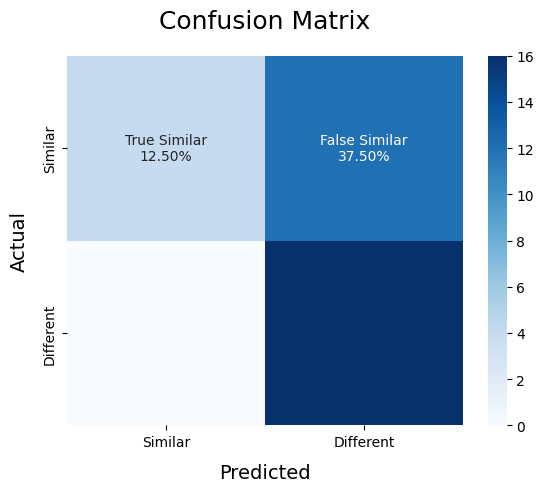

In [6]:
def classify_images(face_list1, face_list2, threshold=1.3):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(face_list1)
    tensor2 = encoder.predict(face_list2)
    
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction
def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)
    
    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


pos_list = np.array([])
neg_list = np.array([])

for data in get_batch(test_triplet, batch_size=16):
    a, p, n = data
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))
    break

ModelMetrics(pos_list, neg_list)